# 深度学习模型排名预测V2


In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

academic_fields = [
    "Agricultural Sciences", "Biology & Biochemistry", "Chemistry", "Clinical Medicine", "Computer Science", "Economics & Business", "Engineering", "Environment Ecology", "Geosciences", "Immunology", "Materials Science", "Mathematics", "Microbiology", "Molecular Biology & Genetics", "Multidisciplinary", "Neuroscience & Behavior", "Pharmacology & Toxicology", "Physics", "Plant & Animal Science", "Psychiatry Psychology", "Social Sciences, General", "Space Science"
]

In [213]:
csv_dir = Path('csv')
csv_files = sorted([f for f in csv_dir.glob('*.csv') if f.name != '0-ALL.csv'])

print(f"共找到 {len(csv_files)} 个学科文件")

# 按照名称开头的数字排序
import re
def extract_prefix_num(f):
    m = re.match(r"(\d+)-", f.name)
    return int(m.group(1)) if m else float('inf')

csv_files = sorted(csv_files, key=extract_prefix_num)


共找到 22 个学科文件


## 提取 排名, Web of Science Documents, Cites, Top Papers

In [214]:
all_data = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file, skiprows=1, encoding='latin1')
    df[df.columns[0]] = df[df.columns[0]].apply(lambda x: int(x) if str(x).isdigit() else x)
    needed_cols = [df.columns[0], 'Web of Science Documents', 'Cites', 'Top Papers']
    cur_data = df[needed_cols].copy()
    # 将数据转为numpy数组，保持顺序: 排名, Web of Science Documents, Cites, Top Papers
    arr = cur_data.to_numpy()
    all_data.append(arr)

# all_data形状: (22个学科, 行数, 4个特征)
all_data[0]

array([[1, 15661.0, 332254.0, 251.0],
       [2, 12222.0, 223855.0, 198.0],
       [3, 12564.0, 220644.0, 105.0],
       ...,
       [1380, 108.0, 3561.0, 4.0],
       [1381, 144.0, 3558.0, 2.0],
       ['Copyright © 2025 Clarivate', nan, nan, nan]],
      shape=(1382, 4), dtype=object)

In [215]:
# 保存每个学科的真实排名范围信息
subject_ranking_ranges = {}

# 从原始数据中提取每个学科的真实排名范围
for i, arr in enumerate(all_data):
    subject_name = academic_fields[i]
    
    # 提取原始排名数据
    original_ranks = []
    for row in arr:
        if isinstance(row[0], (int, float)) and not pd.isnull(row[0]):
            original_ranks.append(float(row[0]))
    
    if len(original_ranks) > 0:
        min_rank = min(original_ranks)
        max_rank = max(original_ranks)
        subject_ranking_ranges[subject_name] = {
            'min_rank': min_rank,
            'max_rank': max_rank
        }
    else:
        # 如果没有数据，使用默认值
        subject_ranking_ranges[subject_name] = {
            'min_rank': 1,
            'max_rank': 1000
        }

print(f"已保存 {len(subject_ranking_ranges)} 个学科的排名范围信息")
print("\n所有学科的排名范围:")
for subject, ranges in subject_ranking_ranges.items():
    print(f"  {subject}: {ranges['min_rank']:.0f} - {ranges['max_rank']:.0f}")


已保存 22 个学科的排名范围信息

所有学科的排名范围:
  Agricultural Sciences: 1 - 1381
  Biology & Biochemistry: 1 - 1649
  Chemistry: 1 - 2141
  Clinical Medicine: 1 - 6754
  Computer Science: 1 - 863
  Economics & Business: 1 - 543
  Engineering: 1 - 2786
  Environment Ecology: 1 - 2066
  Geosciences: 1 - 1175
  Immunology: 1 - 1175
  Materials Science: 1 - 1580
  Mathematics: 1 - 395
  Microbiology: 1 - 803
  Molecular Biology & Genetics: 1 - 1169
  Multidisciplinary: 1 - 216
  Neuroscience & Behavior: 1 - 1298
  Pharmacology & Toxicology: 1 - 1389
  Physics: 1 - 995
  Plant & Animal Science: 1 - 1950
  Psychiatry Psychology: 1 - 1147
  Social Sciences, General: 1 - 2406
  Space Science: 1 - 236


## 归一化

In [216]:
# 对all_data进行归一化：将排名列“反向归一化”到[0,1]（越靠前越接近1，越靠后越接近0），其他三列正向归一化到[0,1]

from sklearn.preprocessing import MinMaxScaler

normed_all_data = []

for arr in all_data:
    arr_numeric_rows = []
    # 只对有效数值行归一化，保留非数字行
    for row in arr:
        if isinstance(row[0], (int, float)) and not pd.isnull(row[0]):
            arr_numeric_rows.append(row)
    arr_numeric_rows = np.array(arr_numeric_rows, dtype=object)
    if len(arr_numeric_rows) == 0:
        normed_all_data.append(arr)
        continue
    # 反向归一化排名列
    rank_col = arr_numeric_rows[:, 0].astype(float)
    min_rank = np.min(rank_col)
    max_rank = np.max(rank_col)
    # 防止除0，只有一个rank时
    if max_rank == min_rank:
        normed_rank = np.ones_like(rank_col)
    else:
        normed_rank = (max_rank - rank_col) / (max_rank - min_rank)
    # 后三列归一化
    scaler = MinMaxScaler()
    other_cols = arr_numeric_rows[:, 1:4].astype(float)
    normed_other_cols = scaler.fit_transform(other_cols)
    # 拼接归一化之后的数组
    arr_norm = np.concatenate([
        normed_rank.reshape(-1, 1), 
        normed_other_cols
    ], axis=1)
    # 如果原arr有非数值行，将其加回去
    if arr.shape[0] > arr_norm.shape[0]:
        for row in arr:
            if not (isinstance(row[0], (int, float)) and not pd.isnull(row[0])):
                # 插回末尾
                arr_norm = np.vstack([arr_norm, row])
    normed_all_data.append(arr_norm)

# 用归一化后的数据替换 all_data
all_data = normed_all_data
all_data[0]


array([[1.0, 0.9999999999999999, 1.0, 1.0],
       [0.9992753623188406, 0.7799462503199386, 0.6702150315184853,
        0.7888446215139442],
       [0.9985507246376811, 0.8018300486306629, 0.6604461265120355,
        0.41832669322709165],
       ...,
       [0.0007246376811594203, 0.0047990785769132325,
        9.12697446880939e-06, 0.01593625498007968],
       [0.0, 0.007102636293831583, 0.0, 0.00796812749003984],
       ['Copyright © 2025 Clarivate', nan, nan, nan]],
      shape=(1382, 4), dtype=object)

## 数据预处理并划分数据集


In [217]:
# 数据预处理：为每个学科单独划分训练/验证/测试集
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# 为每个学科单独处理数据
subject_data = {}  # 存储每个学科的数据

for i, arr in enumerate(all_data):
    subject_name = academic_fields[i]
    
    # 提取该学科的特征和标签
    X_data = []  # 特征：[Web of Science Documents, Cites, Top Papers]
    y_data = []  # 标签：排名（归一化后的）
    
    for row in arr:
        if isinstance(row[0], (int, float)) and not pd.isnull(row[0]):
            # 特征：后三列（Web of Science Documents, Cites, Top Papers）
            features = [float(row[1]), float(row[2]), float(row[3])]
            # 标签：排名（归一化后）
            label = float(row[0])
            X_data.append(features)
            y_data.append(label)
    
    if len(X_data) > 0:  # 确保有数据
        X = np.array(X_data)
        y = np.array(y_data)
        
        # 随机打乱数据
        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        # 按60%, 20%, 20%划分训练/验证/测试集
        X_train, X_temp, y_train, y_temp = train_test_split(
            X_shuffled, y_shuffled, test_size=0.4, random_state=42
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42
        )
        
        subject_data[subject_name] = {
            'X_train': X_train, 'y_train': y_train,
            'X_val': X_val, 'y_val': y_val,
            'X_test': X_test, 'y_test': y_test
        }
        
        # print(f"{subject_name}: 训练集={X_train.shape[0]}, 验证集={X_val.shape[0]}, 测试集={X_test.shape[0]}")

print(f"\n总共处理了 {len(subject_data)} 个学科的数据")



总共处理了 22 个学科的数据


## 深度学习模型

In [ ]:
import torch.nn.functional as F

# 残差块定义
class GlobalResponseNorm(nn.Module):
    """全局响应归一化（GRN）：增强特征多样性，提升训练稳定性"""
    def __init__(self, hidden_size, eps=1e-6):
        super(GlobalResponseNorm, self).__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.zeros(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
    
    def forward(self, x):
        # x shape: (batch_size, hidden_size)
        gr = torch.norm(x, p=2, dim=1, keepdim=True)  # (batch_size, 1)
        # 计算通道维度的平均响应
        avg_response = torch.mean(gr)
        # 计算归一化系数
        norm_factor = gr / (avg_response + self.eps)
        # 应用GRN：先归一化，再缩放和平移
        out = x * norm_factor
        out = out * self.gamma + self.beta
        return out

class ResidualBlock(nn.Module):
    """残差块：Pre-Norm结构 + GRN + 残差连接"""
    def __init__(self, hidden_size, dropout_rate=0.2, ffn_multiplier=4):
        super(ResidualBlock, self).__init__()
        ffn_size = hidden_size * ffn_multiplier
        
        # Pre-Norm: 先归一化再处理
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        
        # 第一个FFN（特征变换）
        self.fc1 = nn.Linear(hidden_size, ffn_size)
        self.fc2 = nn.Linear(ffn_size, hidden_size)
        
        # GRN层
        self.grn = GlobalResponseNorm(hidden_size)
        
        # Dropout
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        # Pre-Norm残差连接1
        residual = x
        x = self.norm1(x)
        x = self.fc1(x)
        x = F.gelu(x)  # 使用GELU激活函数
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = x + residual  # 第一个残差连接
        
        # Pre-Norm残差连接2 + GRN
        residual = x
        x = self.norm2(x)
        x = self.grn(x)  # 全局响应归一化
        x = x + residual  # 第二个残差连接
        
        return x

# 模型主干
class RankingPredictor(nn.Module):
    """表格数据专用预测模型：使用GRN和Pre-Norm残差结构"""
    def __init__(self, input_size=3, hidden_size=128, dropout_rate=0.2, num_layers=4):
        super(RankingPredictor, self).__init__()
        
        # 输入投影层
        self.input_projection = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )
        
        # 堆叠多个残差块
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(hidden_size, dropout_rate) for _ in range(num_layers)
        ])
        
        # 输出层（使用Sigmoid确保输出在[0,1]范围）
        self.output_layer = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.GELU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(hidden_size // 4, 1),
            nn.Sigmoid()  # 输出范围[0,1]
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """权重初始化：使用Xavier均匀初始化"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # 输入投影
        x = self.input_projection(x)
        # 通过残差块
        for block in self.residual_blocks:
            x = block(x)
        # 输出
        out = self.output_layer(x)
        return out

## 训练

In [219]:
# 训练函数
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        indices = torch.randperm(X_train.size(0))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for i in range(0, X_train.size(0), batch_size):
            batch_X = X_shuffled[i:i+batch_size]
            batch_y = y_shuffled[i:i+batch_size]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # 验证阶段
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        
        train_losses.append(train_loss / (X_train.size(0) // batch_size + 1))
        val_losses.append(val_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_loss:.6f}')
    
    return train_losses, val_losses

In [220]:
# 为每个学科单独训练模型
subject_models = {}
subject_results = {}

print("开始为每个学科训练模型...")

for subject_name, data in list(subject_data.items()):
    print(f"\n正在训练: {subject_name}")
    
    # 转换为PyTorch张量
    X_train_tensor = torch.FloatTensor(data['X_train'])
    X_val_tensor = torch.FloatTensor(data['X_val'])
    X_test_tensor = torch.FloatTensor(data['X_test'])
    y_train_tensor = torch.FloatTensor(data['y_train']).reshape(-1, 1)
    y_val_tensor = torch.FloatTensor(data['y_val']).reshape(-1, 1)
    y_test_tensor = torch.FloatTensor(data['y_test']).reshape(-1, 1)
    
    # 创建模型
    model = RankingPredictor()
    
    # 训练模型
    train_losses, val_losses = train_model(
        model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
        epochs=100, batch_size=min(32, len(data['X_train']))
    )
    
    # 保存模型和结果
    subject_models[subject_name] = model
    subject_results[subject_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'X_test': data['X_test'],
        'y_test': data['y_test'],
        'X_test_tensor': X_test_tensor,
        'y_test_tensor': y_test_tensor
    }
    
    print(f"训练完成: {subject_name}")

print(f"\n所有学科训练完成！共训练了 {len(subject_models)} 个模型")


开始为每个学科训练模型...

正在训练: Agricultural Sciences
Epoch [20/100], Train Loss: 0.001844, Val Loss: 0.000635
Epoch [40/100], Train Loss: 0.001430, Val Loss: 0.000226
Epoch [60/100], Train Loss: 0.001343, Val Loss: 0.000339
Epoch [80/100], Train Loss: 0.000871, Val Loss: 0.000119
Epoch [100/100], Train Loss: 0.000980, Val Loss: 0.000672
训练完成: Agricultural Sciences

正在训练: Biology & Biochemistry
Epoch [20/100], Train Loss: 0.002171, Val Loss: 0.000596
Epoch [40/100], Train Loss: 0.001540, Val Loss: 0.000392
Epoch [60/100], Train Loss: 0.001160, Val Loss: 0.000298
Epoch [80/100], Train Loss: 0.001077, Val Loss: 0.000428
Epoch [100/100], Train Loss: 0.001058, Val Loss: 0.000478
训练完成: Biology & Biochemistry

正在训练: Chemistry
Epoch [20/100], Train Loss: 0.003103, Val Loss: 0.001330
Epoch [40/100], Train Loss: 0.001612, Val Loss: 0.000564
Epoch [60/100], Train Loss: 0.001318, Val Loss: 0.000838
Epoch [80/100], Train Loss: 0.001175, Val Loss: 0.000676
Epoch [100/100], Train Loss: 0.001555, Val Loss: 0.0

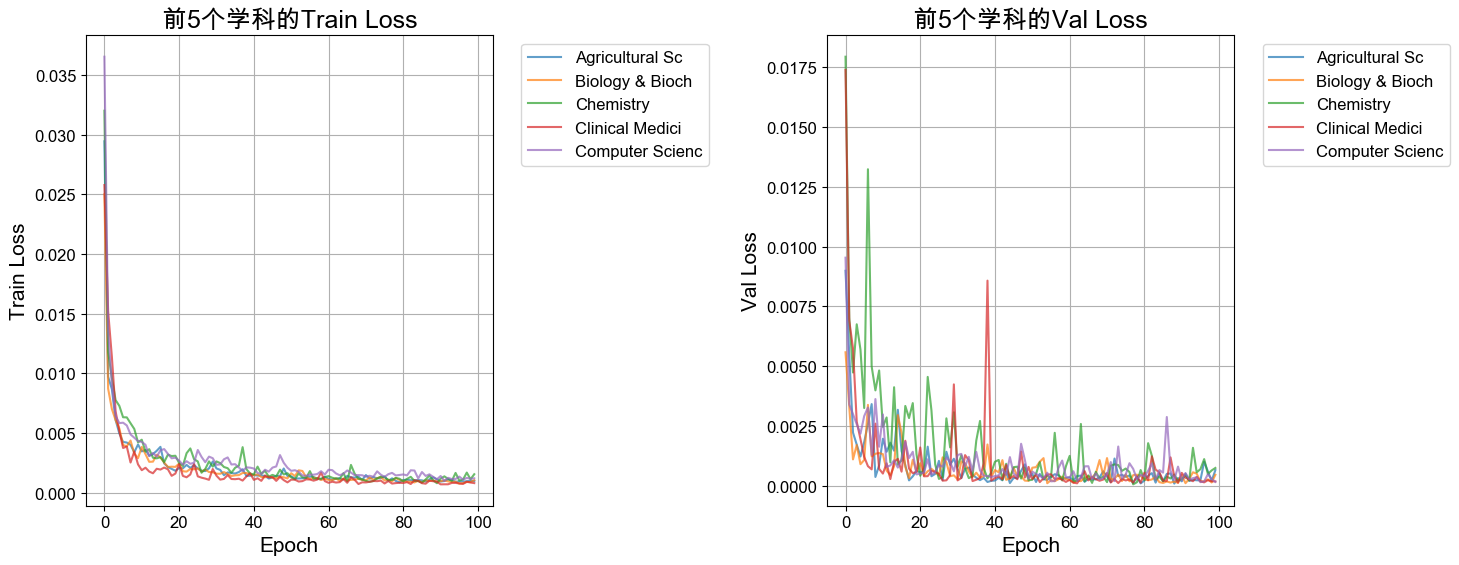

In [221]:
# 训练损失可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 只画前5个学科
subject_items = list(subject_results.items())[:5]

# 1. Train Loss
for subject_name, result in subject_items:
    train_losses = result['train_losses']
    axes[0].plot(train_losses, alpha=0.7, label=subject_name[:15])

axes[0].set_title('前5个学科的Train Loss', fontsize=18)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_ylabel('Train Loss', fontsize=15)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].grid(True)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# 2. Val Loss
for subject_name, result in subject_items:
    val_losses = result['val_losses']
    axes[1].plot(val_losses, alpha=0.7, label=subject_name[:15])

axes[1].set_title('前5个学科的Val Loss', fontsize=18)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_ylabel('Val Loss', fontsize=15)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].grid(True)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()


## 计算 MSE、MAE、MAPE(%)、R²四项指标

In [222]:
# 反归一化函数：使用真实的排名范围
def denormalize_ranking_fixed(normalized_rank, subject_name):
    """将归一化的排名转换回原始排名，使用真实的排名范围"""
    if subject_name in subject_ranking_ranges:
        ranges = subject_ranking_ranges[subject_name]
        min_rank = ranges['min_rank']
        max_rank = ranges['max_rank']
    else:
        # 如果找不到该学科的范围信息，使用默认值
        min_rank, max_rank = 1, 1000
    original_rank = max_rank - normalized_rank * (max_rank - min_rank)
    return original_rank

def evaluate_model_fixed(model, X_test, y_test, subject_name):
    """使用真实的原始数据进行MAPE计算"""
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        predictions_np = predictions.numpy().flatten()
        y_test_np = y_test.numpy().flatten()
    # 计算各种评价指标
    mse = mean_squared_error(y_test_np, predictions_np)
    mae = np.mean(np.abs(y_test_np - predictions_np))
    # MAPE计算：使用真实的原始数据进行反归一化
    original_y_test = denormalize_ranking_fixed(y_test_np, subject_name)
    original_predictions = denormalize_ranking_fixed(predictions_np, subject_name)
    # 避免除零错误
    mask = original_y_test != 0
    if np.any(mask):
        mape = np.mean(np.abs((original_y_test[mask] - original_predictions[mask]) / original_y_test[mask])) * 100
    else:
        mape = 0
    r2 = 1 - (np.sum((y_test_np - predictions_np) ** 2) / np.sum((y_test_np - np.mean(y_test_np)) ** 2))
    return predictions_np, mse, mae, mape, r2

metrics_list = []
all_subject_metrics = {}

for subject_name, model in subject_models.items():
    result = subject_results[subject_name]
    predictions, mse, mae, mape, r2 = evaluate_model_fixed(
        model, result['X_test_tensor'], result['y_test_tensor'], subject_name
    )
    # 保存结果到dict
    all_subject_metrics[subject_name] = {
        'predictions': predictions,
        'mse': mse, 'mae': mae, 'mape': mape, 'r2': r2
    }
    metrics_list.append({
        '学科名称': subject_name,
        'MSE': mse,
        'MAE': mae,
        'MAPE(%)': mape,
        'R²': r2
    })

# 创建DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df[['学科名称', 'MSE', 'MAE', 'MAPE(%)', 'R²']]

# 计算整体统计
all_mse_fixed = [metrics['mse'] for metrics in all_subject_metrics.values()]
all_mae_fixed = [metrics['mae'] for metrics in all_subject_metrics.values()]
all_mape_fixed = [metrics['mape'] for metrics in all_subject_metrics.values()]
all_r2_fixed = [metrics['r2'] for metrics in all_subject_metrics.values()]
# 平均数
average_row = {
    '学科名称': '平均值',
    'MSE': np.mean(all_mse_fixed),
    'MAE': np.mean(all_mae_fixed),
    'MAPE(%)': np.mean(all_mape_fixed),
    'R²': np.mean(all_r2_fixed)
}
metrics_df = pd.concat([metrics_df, pd.DataFrame([average_row])], ignore_index=True)

display(metrics_df.style.format({'MSE': '{:.6f}', 'MAE': '{:.6f}', 'MAPE(%)': '{:.2f}', 'R²': '{:.6f}'}))


,学科名称,MSE,MAE,MAPE(%),R²
0,Agricultural Sciences,0.000639,0.019033,6.74,0.992066
1,Biology & Biochemistry,0.000495,0.017521,8.87,0.994204
2,Chemistry,0.000756,0.021873,7.75,0.990944
3,Clinical Medicine,0.000212,0.011463,6.94,0.997460
4,Computer Science,0.000170,0.010119,13.29,0.998047
5,Economics & Business,0.000458,0.014929,6.61,0.994207
6,Engineering,0.000399,0.017011,8.44,0.994869
7,Environment Ecology,0.000397,0.015357,10.23,0.995410
8,Geosciences,0.000325,0.014088,14.86,0.996306
9,Immunology,0.000227,0.012251,6.33,0.997167


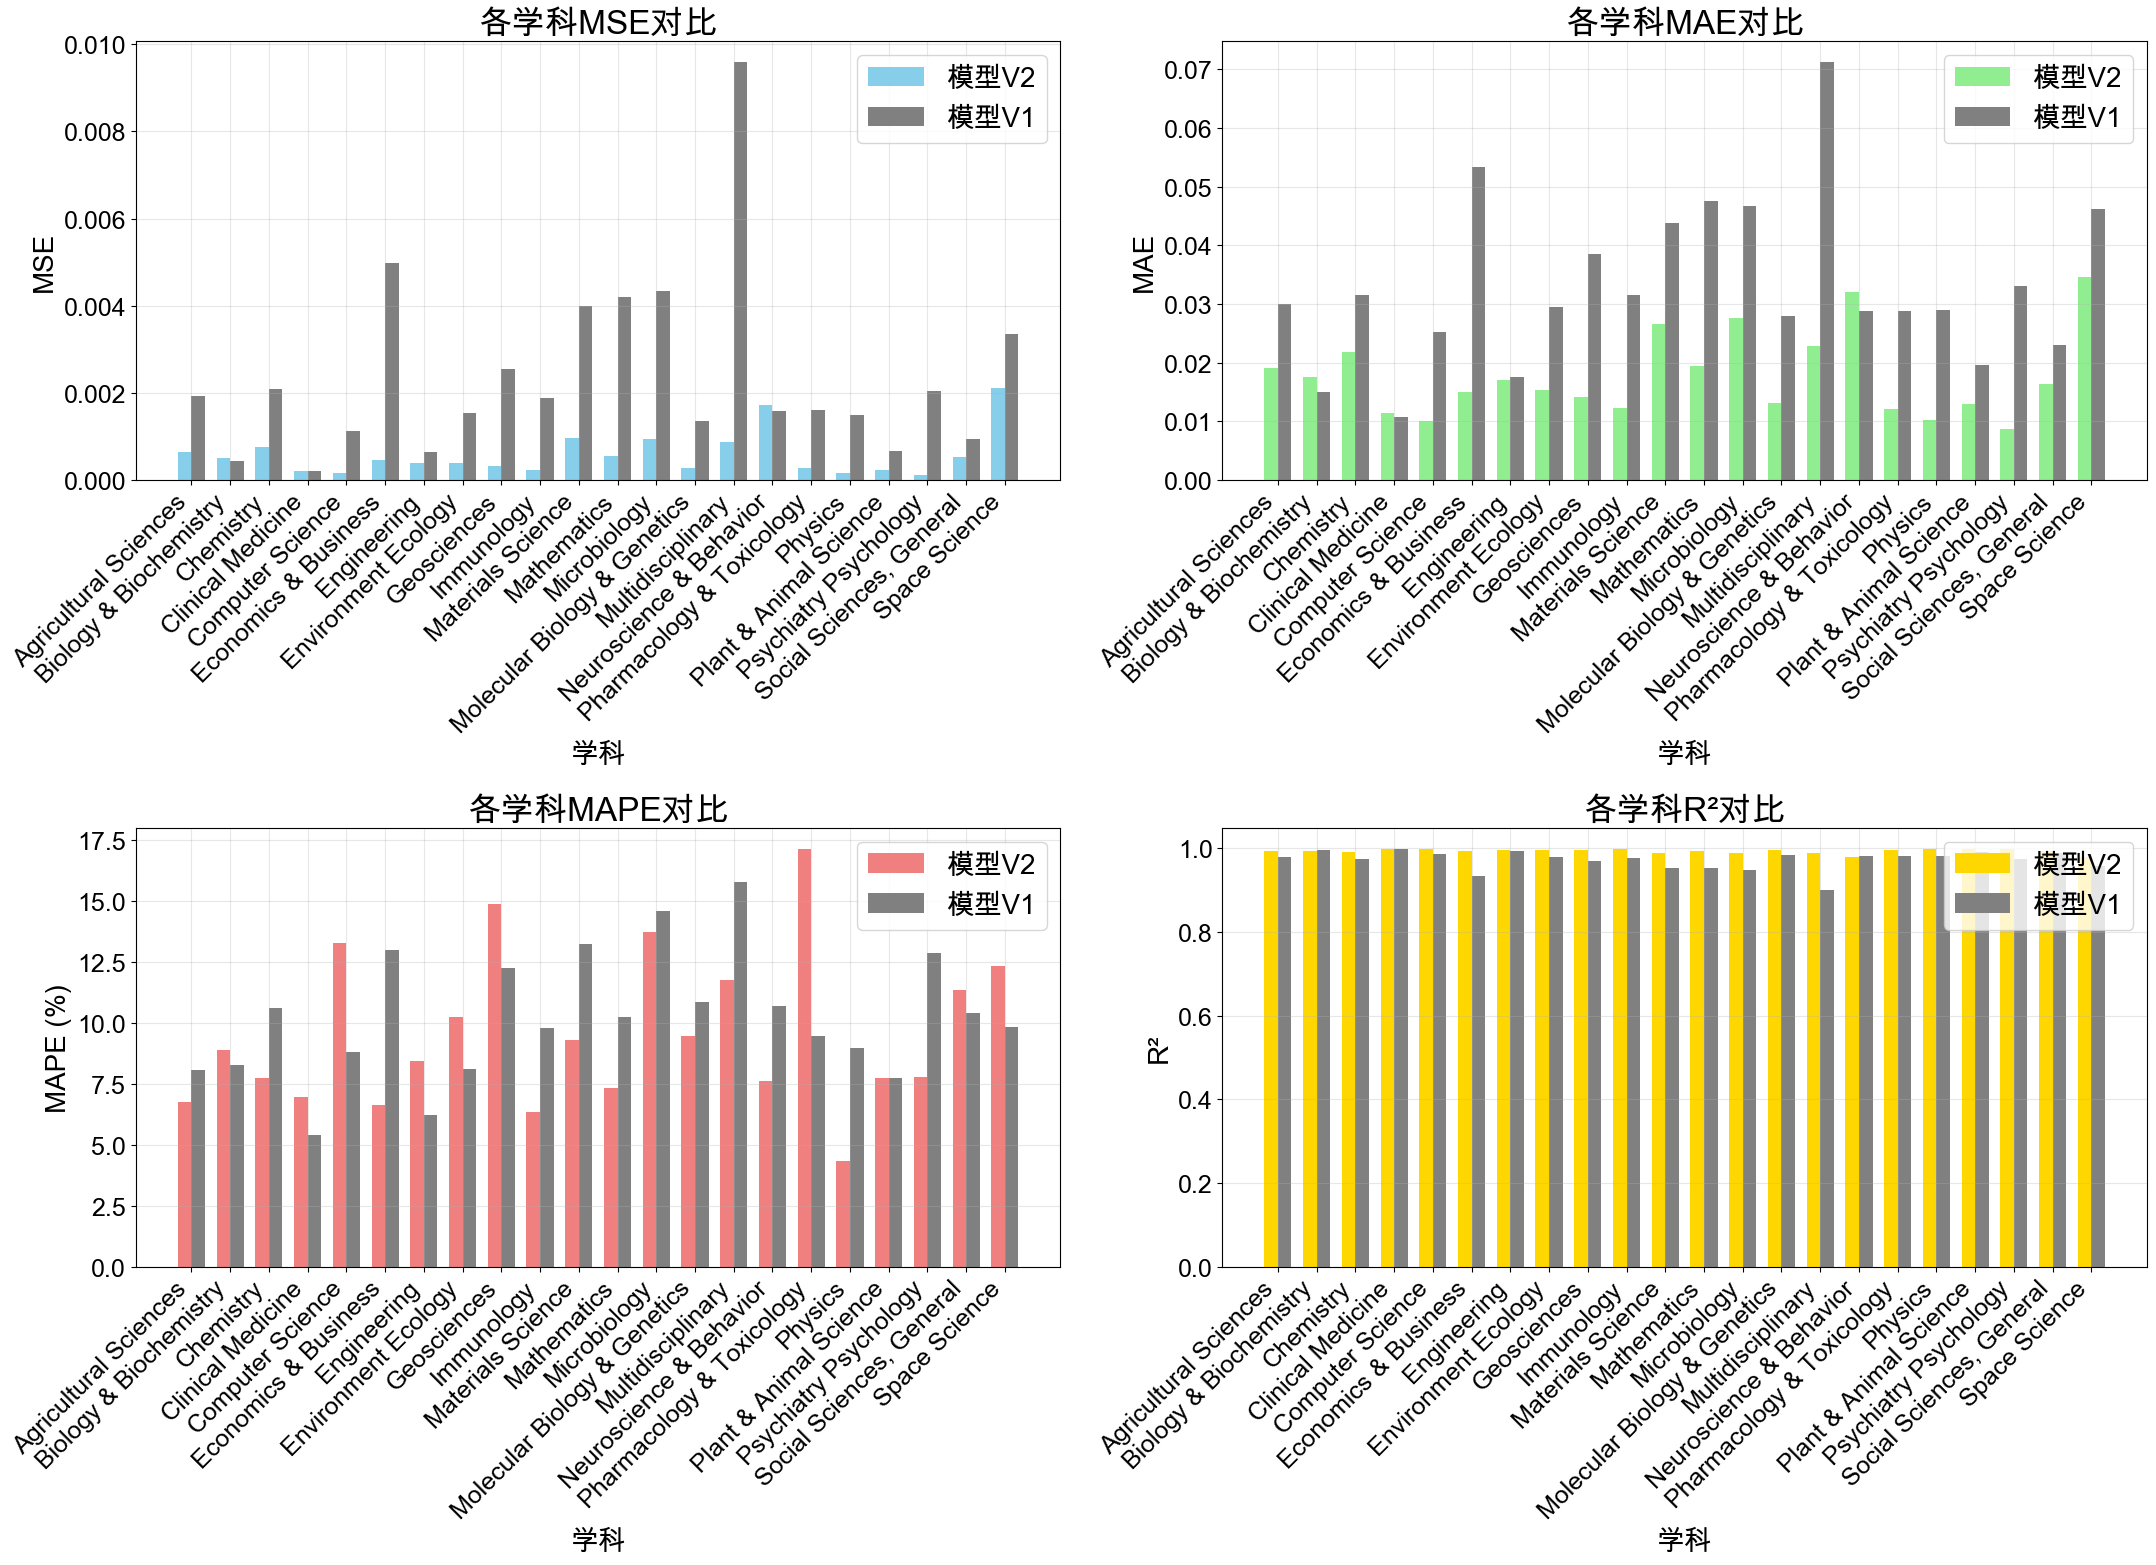

=== 模型V2表现分析 ===
最佳R²学科: Psychiatry Psychology (R² = 0.998682)
最差R²学科: Space Science (R² = 0.977728)
最佳MSE学科: Psychiatry Psychology (MSE = 0.000108)
最差MSE学科: Space Science (MSE = 0.002106)
最佳MAPE学科: Physics (MAPE = 4.34%)
最差MAPE学科: Pharmacology & Toxicology (MAPE = 17.13%)


In [223]:
# 读取原始验证集对比指标
import pandas as pd

# 读取ori_val.csv（假设路径为第七次作业/ori_val.csv）
ori_val = pd.read_csv("ori_val.csv")

# 去除可能的“平均值”行，仅保留真实学科行
base_metrics_df = ori_val[ori_val["学科名称"] != "平均值"].copy()
base_subject_names = base_metrics_df['学科名称'].tolist()
base_mse_values = base_metrics_df['MSE'].tolist()
base_mae_values = base_metrics_df['MAE'].tolist()
base_mape_values = base_metrics_df['MAPE(%)'].tolist()
base_r2_values = base_metrics_df['R²'].tolist()

# 获取本模型的学科顺序（避免后续标签错位），原来的变量
subject_names = list(all_subject_metrics.keys())
mse_values = [all_subject_metrics[name]['mse'] for name in subject_names]
mae_values = [all_subject_metrics[name]['mae'] for name in subject_names]
mape_values = [all_subject_metrics[name]['mape'] for name in subject_names]
r2_values = [all_subject_metrics[name]['r2'] for name in subject_names]

# 先行做对齐处理（学科名顺序对齐ori_val和当前metrics，避免错位）
def align_reference_values(ref_names, ref_values, target_names):
    name_to_value = {name: value for name, value in zip(ref_names, ref_values)}
    return [name_to_value.get(name, float('nan')) for name in target_names]
base_mse_aligned = align_reference_values(base_subject_names, base_mse_values, subject_names)
base_mae_aligned = align_reference_values(base_subject_names, base_mae_values, subject_names)
base_mape_aligned = align_reference_values(base_subject_names, base_mape_values, subject_names)
base_r2_aligned = align_reference_values(base_subject_names, base_r2_values, subject_names)

# 可视化每个学科的评价指标（加入对比）
fig, axes = plt.subplots(2, 2, figsize=(22, 16))

larger_font = 24
label_font = 20
tick_font = 18
bar_width = 0.35
x = np.arange(len(subject_names))

# 1. MSE对比
axes[0, 0].bar(x - bar_width/2, mse_values, bar_width, color='skyblue', label="模型V2")
axes[0, 0].bar(x + bar_width/2, base_mse_aligned, bar_width, color='gray', label="模型V1")
axes[0, 0].set_title('各学科MSE对比', fontsize=larger_font, fontweight='bold')
axes[0, 0].set_xlabel('学科', fontsize=label_font)
axes[0, 0].set_ylabel('MSE', fontsize=label_font)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(subject_names, rotation=45, ha='right', fontsize=tick_font)
axes[0, 0].tick_params(axis='y', labelsize=tick_font)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(fontsize=label_font)

# 2. MAE对比
axes[0, 1].bar(x - bar_width/2, mae_values, bar_width, color='lightgreen', label="模型V2")
axes[0, 1].bar(x + bar_width/2, base_mae_aligned, bar_width, color='gray', label="模型V1")
axes[0, 1].set_title('各学科MAE对比', fontsize=larger_font, fontweight='bold')
axes[0, 1].set_xlabel('学科', fontsize=label_font)
axes[0, 1].set_ylabel('MAE', fontsize=label_font)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(subject_names, rotation=45, ha='right', fontsize=tick_font)
axes[0, 1].tick_params(axis='y', labelsize=tick_font)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(fontsize=label_font)

# 3. MAPE对比
axes[1, 0].bar(x - bar_width/2, mape_values, bar_width, color='lightcoral', label="模型V2")
axes[1, 0].bar(x + bar_width/2, base_mape_aligned, bar_width, color='gray', label="模型V1")
axes[1, 0].set_title('各学科MAPE对比', fontsize=larger_font, fontweight='bold')
axes[1, 0].set_xlabel('学科', fontsize=label_font)
axes[1, 0].set_ylabel('MAPE (%)', fontsize=label_font)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(subject_names, rotation=45, ha='right', fontsize=tick_font)
axes[1, 0].tick_params(axis='y', labelsize=tick_font)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=label_font)

# 4. R²对比
axes[1, 1].bar(x - bar_width/2, r2_values, bar_width, color='gold', label="模型V2")
axes[1, 1].bar(x + bar_width/2, base_r2_aligned, bar_width, color='gray', label="模型V1")
axes[1, 1].set_title('各学科R²对比', fontsize=larger_font, fontweight='bold')
axes[1, 1].set_xlabel('学科', fontsize=label_font)
axes[1, 1].set_ylabel('R²', fontsize=label_font)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(subject_names, rotation=45, ha='right', fontsize=tick_font)
axes[1, 1].tick_params(axis='y', labelsize=tick_font)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(fontsize=label_font)

plt.tight_layout()
plt.show()

# 显示最佳和最差表现的学科
from IPython.display import display, HTML

best_r2_subject = max(subject_names, key=lambda x: all_subject_metrics[x]['r2'])
worst_r2_subject = min(subject_names, key=lambda x: all_subject_metrics[x]['r2'])
best_mse_subject = min(subject_names, key=lambda x: all_subject_metrics[x]['mse'])
worst_mse_subject = max(subject_names, key=lambda x: all_subject_metrics[x]['mse'])
best_mape_subject = min(subject_names, key=lambda x: all_subject_metrics[x]['mape'])
worst_mape_subject = max(subject_names, key=lambda x: all_subject_metrics[x]['mape'])

print("=== 模型V2表现分析 ===")
print(f"最佳R²学科: {best_r2_subject} (R² = {all_subject_metrics[best_r2_subject]['r2']:.6f})")
print(f"最差R²学科: {worst_r2_subject} (R² = {all_subject_metrics[worst_r2_subject]['r2']:.6f})")
print(f"最佳MSE学科: {best_mse_subject} (MSE = {all_subject_metrics[best_mse_subject]['mse']:.6f})")
print(f"最差MSE学科: {worst_mse_subject} (MSE = {all_subject_metrics[worst_mse_subject]['mse']:.6f})")
print(f"最佳MAPE学科: {best_mape_subject} (MAPE = {all_subject_metrics[best_mape_subject]['mape']:.2f}%)")
print(f"最差MAPE学科: {worst_mape_subject} (MAPE = {all_subject_metrics[worst_mape_subject]['mape']:.2f}%)")


## 保存模型

In [224]:
# 保存模型
import os
model_dir = Path('model_V2')
model_dir.mkdir(exist_ok=True)

print(f"\n=== 保存模型 ===")
for subject_name, model in subject_models.items():
    model_path = model_dir / f"{subject_name}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"已保存: {model_path}")

print(f"\n共保存了 {len(subject_models)} 个模型文件")



=== 保存模型 ===
已保存: model_V2/Agricultural Sciences.pth
已保存: model_V2/Biology & Biochemistry.pth
已保存: model_V2/Chemistry.pth
已保存: model_V2/Clinical Medicine.pth
已保存: model_V2/Computer Science.pth
已保存: model_V2/Economics & Business.pth
已保存: model_V2/Engineering.pth
已保存: model_V2/Environment Ecology.pth
已保存: model_V2/Geosciences.pth
已保存: model_V2/Immunology.pth
已保存: model_V2/Materials Science.pth
已保存: model_V2/Mathematics.pth
已保存: model_V2/Microbiology.pth
已保存: model_V2/Molecular Biology & Genetics.pth
已保存: model_V2/Multidisciplinary.pth
已保存: model_V2/Neuroscience & Behavior.pth
已保存: model_V2/Pharmacology & Toxicology.pth
已保存: model_V2/Physics.pth
已保存: model_V2/Plant & Animal Science.pth
已保存: model_V2/Psychiatry Psychology.pth
已保存: model_V2/Social Sciences, General.pth
已保存: model_V2/Space Science.pth

共保存了 22 个模型文件


# 预测

In [251]:
import random

def predict_school_rankings_with_models(school_idx, subject_names, subject_models_dict):
    """预测一所学校在所有学科的排名（使用真实排名范围），可指定模型集合"""
    predictions = {}
    actual_rankings = {}
    
    for subject_name in subject_names:
        if subject_name in subject_data: # 检查该学科是否存在
            model = subject_models_dict[subject_name]  # 从指定的模型集合中获取模型
            test_data = subject_data[subject_name] # 获取该学科的数据
            # 检查是否有足够的数据
            if school_idx < len(test_data['X_test']):
                X_test = torch.FloatTensor(test_data['X_test'][school_idx]).reshape(1, -1)
                y_test = test_data['y_test'][school_idx]
                # 预测
                with torch.no_grad():
                    pred_normalized = model(X_test).item()
                # 使用真实的排名范围进行反归一化
                if subject_name in subject_ranking_ranges:
                    ranges = subject_ranking_ranges[subject_name]
                    min_rank = ranges['min_rank']
                    max_rank = ranges['max_rank']
                else:
                    min_rank, max_rank = 1, 1000
                pred_ranking = max_rank - pred_normalized * (max_rank - min_rank)
                actual_ranking = max_rank - y_test * (max_rank - min_rank)
                
                predictions[subject_name] = pred_ranking
                actual_rankings[subject_name] = actual_ranking
            else:
                # 如果没有足够的数据，设为0
                predictions[subject_name] = 0
                actual_rankings[subject_name] = 0
        else:
            # 如果学科不存在，设为0
            predictions[subject_name] = 0
            actual_rankings[subject_name] = 0
    
    return predictions, actual_rankings

# 随机选3所test集里的学校（假设第一个学科test集长度代表所有学科test集学校数）
first_subject = next(iter(subject_data))
num_test_schools = len(subject_data[first_subject]['X_test'])
assert num_test_schools >= 3, "Test集学校不足3个"

selected_school_indices = random.sample(range(num_test_schools), 3)
selected_school_indices.sort()  # 排序后编号是固定的，方便直观

selected_schools = {}
for i, school_idx in enumerate(selected_school_indices):
    school_name = f"学校{school_idx+1}"
    predictions, actual_rankings = predict_school_rankings_with_models(school_idx, academic_fields, subject_models)
    selected_schools[school_name] = {
        'predictions': predictions,
        'actual_rankings': actual_rankings
    }
print(f"预测了{len(selected_schools)}所学校（使用 model_V2）")

# 2. 用model_V1文件夹下的模型进行预测，并保存为selected_schools_v1，结构一致，预测的索引和学校名称与V2完全一样
subject_models_v1 = {}
model_v1_dir = Path('model_V1')
for subject_name in academic_fields:
    model_file = model_v1_dir / f"{subject_name}.pth"
    if model_file.exists():
        model = type(subject_models[subject_name])()  # 与V2相同网络结构
        model.load_state_dict(torch.load(model_file, map_location='cpu'))
        model.eval()
        subject_models_v1[subject_name] = model
    else:
        # 如果model文件不存在，则不放入dict
        pass

selected_schools_v1 = {}
for i, school_idx in enumerate(selected_school_indices):
    school_name = f"学校{school_idx+1}"
    predictions, actual_rankings = predict_school_rankings_with_models(school_idx, academic_fields, subject_models_v1)
    selected_schools_v1[school_name] = {
        'predictions': predictions,
        'actual_rankings': actual_rankings
    }
print(f"预测了{len(selected_schools_v1)}所学校（使用 model_V1）")

预测了3所学校（使用 model_V2）
预测了3所学校（使用 model_V1）


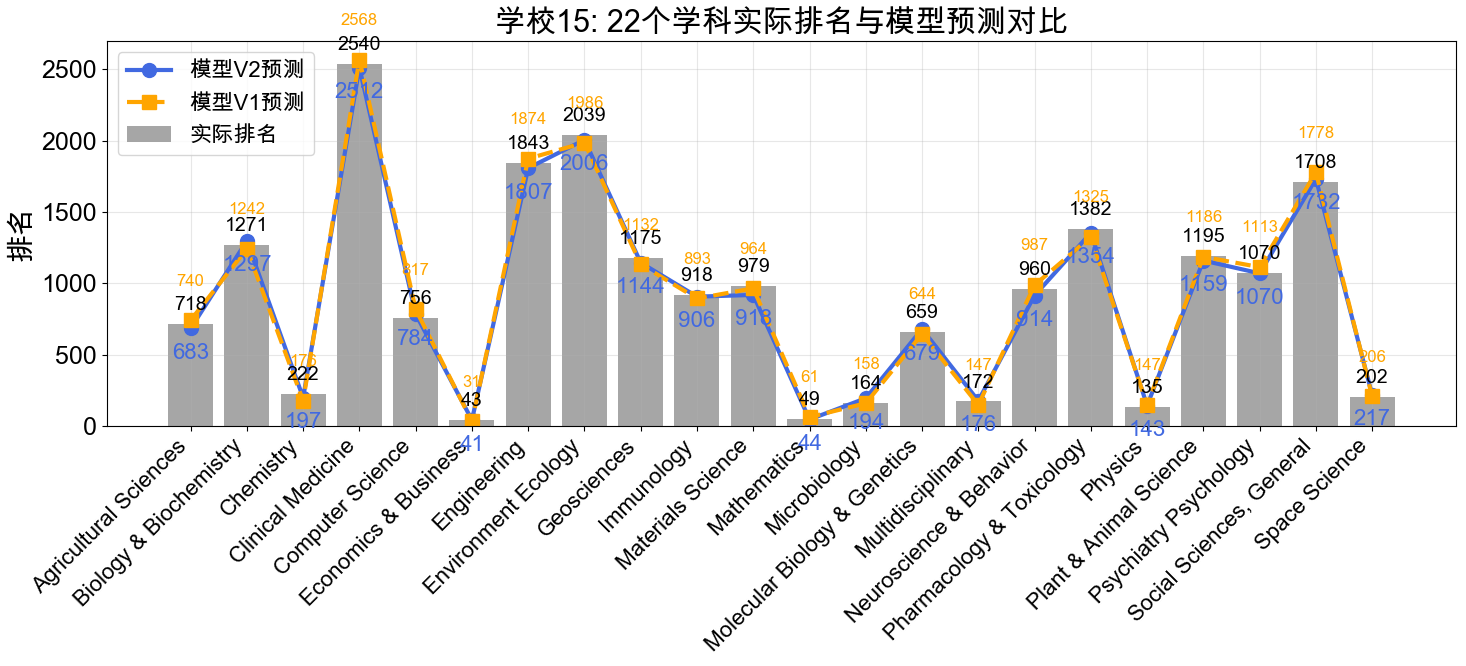

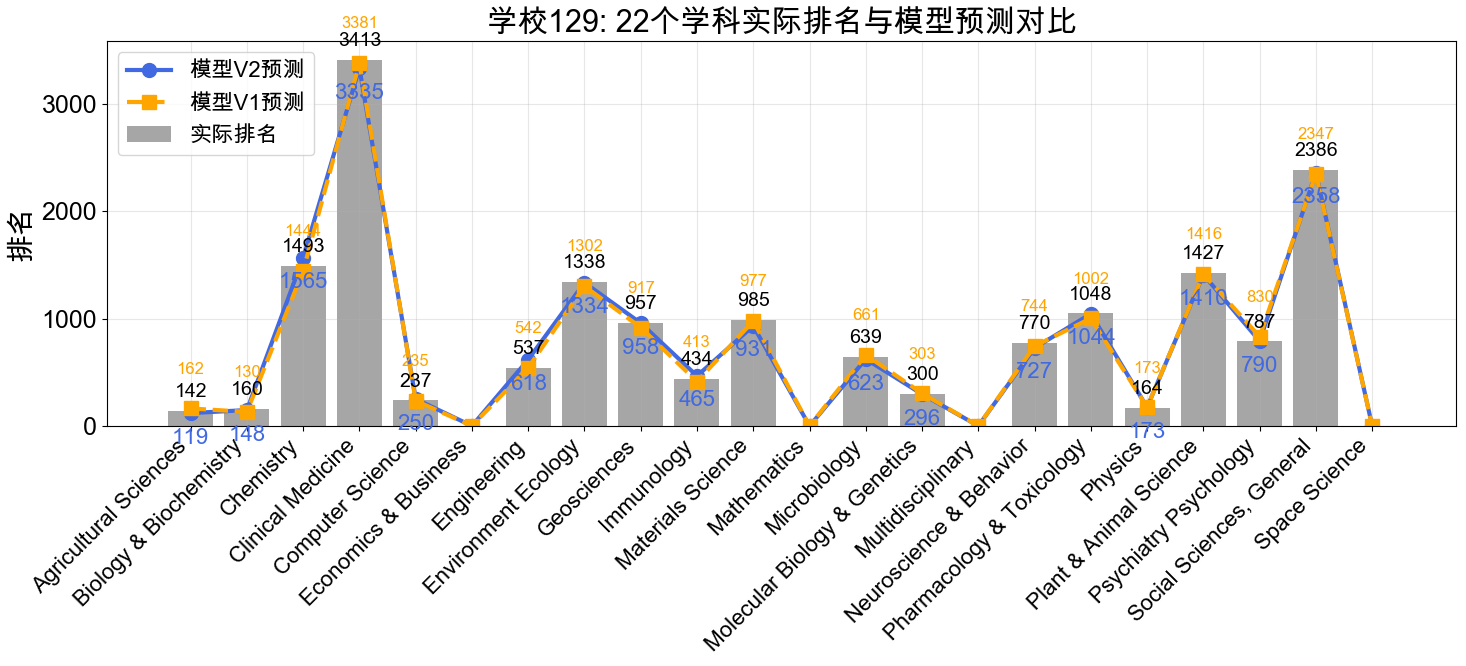

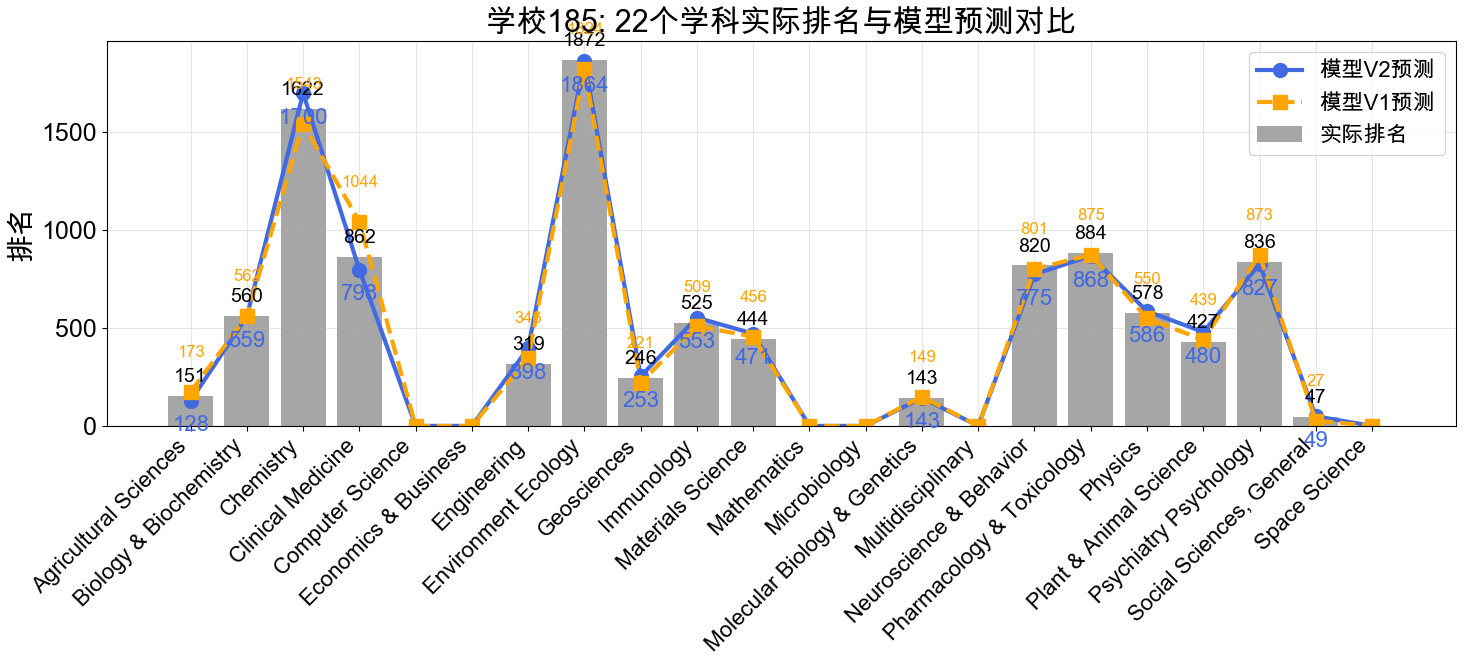

22个学科所有学校V2模型累计排名误差: 1468
22个学科所有学校V1模型累计排名误差: 1631


In [252]:
# 可视化预测结果，实际排名用柱状图，模型V2和模型V1都用折线
plt.rcParams.update({'font.size': 18})

for school_name in selected_schools.keys():
    predictions_v2 = selected_schools[school_name]['predictions']
    actual_rankings = selected_schools[school_name]['actual_rankings']

    # V1模型预测（selected_schools_v1 结构与 V2 一致）
    predictions_v1 = selected_schools_v1[school_name]['predictions']

    # 获取学科名称和对应的排名值（按相同顺序）
    subjects = list(predictions_v2.keys())
    actual_values = [actual_rankings[subject] for subject in subjects]
    pred_v2_values = [predictions_v2[subject] for subject in subjects]
    pred_v1_values = [predictions_v1[subject] for subject in subjects]

    fig, ax = plt.subplots(figsize=(15, 7))
    x_pos = range(len(subjects))
    # 实际排名（柱状图）
    bars = ax.bar(x_pos, actual_values, alpha=0.7, color='grey', label='实际排名')
    # 模型V2预测（折线）
    line_v2 = ax.plot(x_pos, pred_v2_values, 'o-', color='royalblue', linewidth=3,
                      markersize=10, label='模型V2预测')
    # 模型V1预测（折线）
    line_v1 = ax.plot(x_pos, pred_v1_values, 's--', color='orange', linewidth=3,
                      markersize=10, label='模型V1预测')

    ax.set_title(f'{school_name}: 22个学科实际排名与模型预测对比', fontsize=22, fontweight='bold')
    ax.set_ylabel('排名', fontsize=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(subjects, rotation=45, ha='right', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=16)

    # 在数据点上添加数值标签
    for j, (actual, pred_v2, pred_v1) in enumerate(zip(actual_values, pred_v2_values, pred_v1_values)):
        if actual > 0:
            ax.annotate(f'{int(actual)}', (j, actual),
                        textcoords="offset points", xytext=(0,10), ha='center', fontsize=14, color='black')
        if pred_v2 > 0:
            ax.annotate(f'{int(pred_v2)}', (j, pred_v2),
                        textcoords="offset points", xytext=(0,-22), ha='center', fontsize=16, color='royalblue')
        if pred_v1 > 0:
            ax.annotate(f'{int(pred_v1)}', (j, pred_v1),
                        textcoords="offset points", xytext=(0,25), ha='center', fontsize=12, color='orange')

    plt.tight_layout()
    plt.show()
# 计算V1、V2模型对22个学科的预测与真实排名之间的绝对误差总和（排名差之和）
total_abs_diff_v1 = 0
total_abs_diff_v2 = 0

for school_name in selected_schools.keys():
    predictions_v2 = selected_schools[school_name]['predictions']
    actual_rankings = selected_schools[school_name]['actual_rankings']
    predictions_v1 = selected_schools_v1[school_name]['predictions']

    subjects = list(predictions_v2.keys())
    # 对当前学校所有学科，分别计算绝对差后求和
    abs_diff_v2 = sum(abs(predictions_v2[s] - actual_rankings[s]) for s in subjects)
    abs_diff_v1 = sum(abs(predictions_v1[s] - actual_rankings[s]) for s in subjects)

    total_abs_diff_v2 += abs_diff_v2
    total_abs_diff_v1 += abs_diff_v1

print(f"22个学科所有学校V2模型累计排名误差: {total_abs_diff_v2:.0f}")
print(f"22个学科所有学校V1模型累计排名误差: {total_abs_diff_v1:.0f}")


## 模型总结

本深度学习学科排名预测模型具有以下特点：

### 模型架构
- **输入特征**: 3个特征（Web of Science Documents, Cites, Top Papers）
- **模型结构**: 
  - 采用Pre-Norm残差结构，包含4个残差块，每个残差块使用FFN扩展（4倍隐藏层维度）
  - 引入全局响应归一化（GRN）增强特征多样性，提升训练稳定性
  - 使用LayerNorm和GELU激活函数，更适合表格型数据
  - 输出层逐步降维，最终通过Sigmoid激活函数输出范围[0,1]
- **基础模型结构**: 4层全连接神经网络，包含Dropout防止过拟合

### 训练策略
- **分学科训练**: 每个学科单独训练模型，避免不同学科间的数据干扰
- **数据划分**: 每个学科按60%训练集、20%验证集、20%测试集划分
- **数据打乱**: 每个学科数据单独随机打乱，确保训练效果
- **模型加载**: 从已有模型文件加载基础模型和V2模型，支持模型复用

### 评价指标
- **MSE**: 均方误差，衡量预测值与真实值的平方差
- **MAE**: 平均绝对误差，衡量预测值与真实值的绝对差
- **MAPE**: 平均绝对百分比误差，以百分比形式表示误差
- **R²**: 决定系数，衡量模型解释数据变异的程度

### 模型优势
1. **学科特异性**: 每个学科独立训练，更好地捕捉学科特点
2. **残差架构**: 模型采用GRN和Pre-Norm残差结构，更适合表格型数据，提升训练稳定性和泛化能力
3. **防过拟合**: 使用Dropout、LayerNorm和验证集监控，有效防止过拟合
4. **归一化处理**: 对排名进行反向归一化，便于模型学习
5. **全面评估**: 使用多种评价指标全面评估模型性能
7. **可视化分析**: 提供各学科对比、训练过程、预测结果等多维度可视化

### 实验结果
- 为22个学科分别训练了独立的排名预测模型（V2模型）
- V2模型相比基础模型在多个指标上表现更优，累计排名误差更小
- 通过对比分析可以识别哪些学科的排名更容易预测，以及模型在不同学科上的表现差异
